# Haryana demand simulation for day 1

## Constraints for the simulation

 1. Simulated demand at 03:00 AM should be equal to 3559 MW.
 2. Simulated demand at 07:00 AM should be equal to 6101 MW.
 3. All the simulated load values should be greater than zero.
 4. Sum of Inhouse Power(simulated values) should be equal to 50.07 * 1000 == 50700 MWh
 5. Total Consumption should be equal to 109440 MWh (but national grid + inhouse production is equal to 110577.55)
 6. Maximum generation capacity of inhouse power(simulated values) should be less than equal to 3000
 
 #### *The fifth constraint needs discussion*

## *MODEL*

In [1]:
#Simulation for day1

from pyomo.environ import *
import numpy as np
import data
# create a model
model = ConcreteModel()

# declare decision variables
model.x = Var(data.N ,bounds=(0,3000), within=NonNegativeReals)

def obj_rule(model):
    return sum((data.national_grid[i] + model.x[i] - data.adjusted_curve[i])**2  for i in data.N) 
    

model.obj = Objective(rule=obj_rule,sense =1)

# declare constraints

# Total demand at time 03:00 AM should be equal to 3559.
model.con1 = Constraint(expr = model.x[12] + data.national_grid[12] == 3559)
# Total demand at time 07:00 PM should be equal to 6101.
model.con2 = Constraint(expr = model.x[76] + data.national_grid[76] == 6101)

# Total of inhouse production for day 1 should be equal to 50700 MWh.
def con_rule3(model):
    return sum(model.x[i] for i in data.N)/4 == 50700

model.con3 = Constraint(rule=con_rule3)



def con_rule4(model):
    return sum(model.x[i] + data.national_grid[i] for i in data.N)/4  == 110577.55 #109440
model.con4 = Constraint(rule=con_rule4)

## *Solving the optimization problem using non linear solver "ipopt"* 

### *The problem converged and terminated at optimal point*

In [2]:
SolverFactory('ipopt', executable='ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 96
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.015735387802124023
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


# *Converting the results into a dataframe*

In [3]:
import pandas as pd
import numpy as np

df = pd.read_excel('data.xlsx')
del df['Time Block']

#saving the solution

solution = []

for i in range(96):
    solution.append(model.x[i].value)


optimized = pd.DataFrame(solution,columns=['Simulation_results'])

df['In-house(simulated)'] = optimized['Simulation_results'] 

df['Total_simulated_demand'] = df['In-house(simulated)'] + df['Outside State (MW)']

# *Visualizing the results*

In [4]:
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'],errors = 'ignore')
df.set_index('Time Stamp',inplace= True)

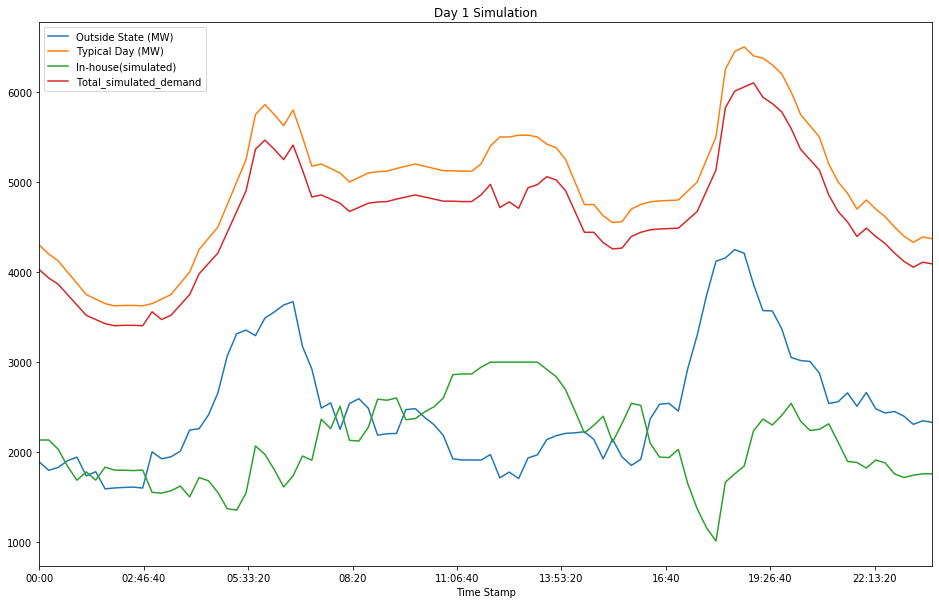

In [5]:
%matplotlib inline
df.plot(figsize=(16,10),title="Day 1 Simulation",fontsize=10.0)